In [2]:
#import necessary python libraries
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize
import pandas as pd
import math
from JSON_to_DF import JSON_to_DataFrame
from Lightcurve_class import *
import celerite
%matplotlib notebook

In [3]:
#create new supernovae object
SN2011fe = Supernovae("../../../OSC_data/JSON_data/SN2011fe.json")
SN2011fe.load_LightCurves()
SN2011fe.meta_data()

/Users/ethanmarx/anaconda/envs/NUREU17/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['band', 'source', 'telescope']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [4]:
a = 1
c = 1
bounds = dict(log_a = (-15,15), log_c = (-15,15))
kernel = celerite.terms.RealTerm(log_a = np.log(a), log_c = np.log(c), bounds=bounds)


In [5]:
#Grab flux, times, and flux errors from supernovae object
flux = SN2011fe.Lightcurves['Rc_12'].flux
time = SN2011fe.Lightcurves['Rc_12'].time
flux_err = SN2011fe.Lightcurves['Rc_12'].flux_err

#Calculate the mean of the flux
mean = np.mean(flux)

#Create gaussian process with given kernel and mean
gp = celerite.GP(kernel, mean=mean)

gp.compute(time, flux_err)

gp.log_likelihood(flux)


-139.24417811424334

In [6]:
#Define function to return negative log likelihood given parameters and flux values
def neg_log_like(params, flux, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(flux)

#Grab initial parameters and bounds
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(flux, gp))

gp.set_parameter_vector(r.x)

In [7]:
x = np.linspace(time[0], time[-1], 10000)
pred_mean, pred_var = gp.predict(flux, time, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


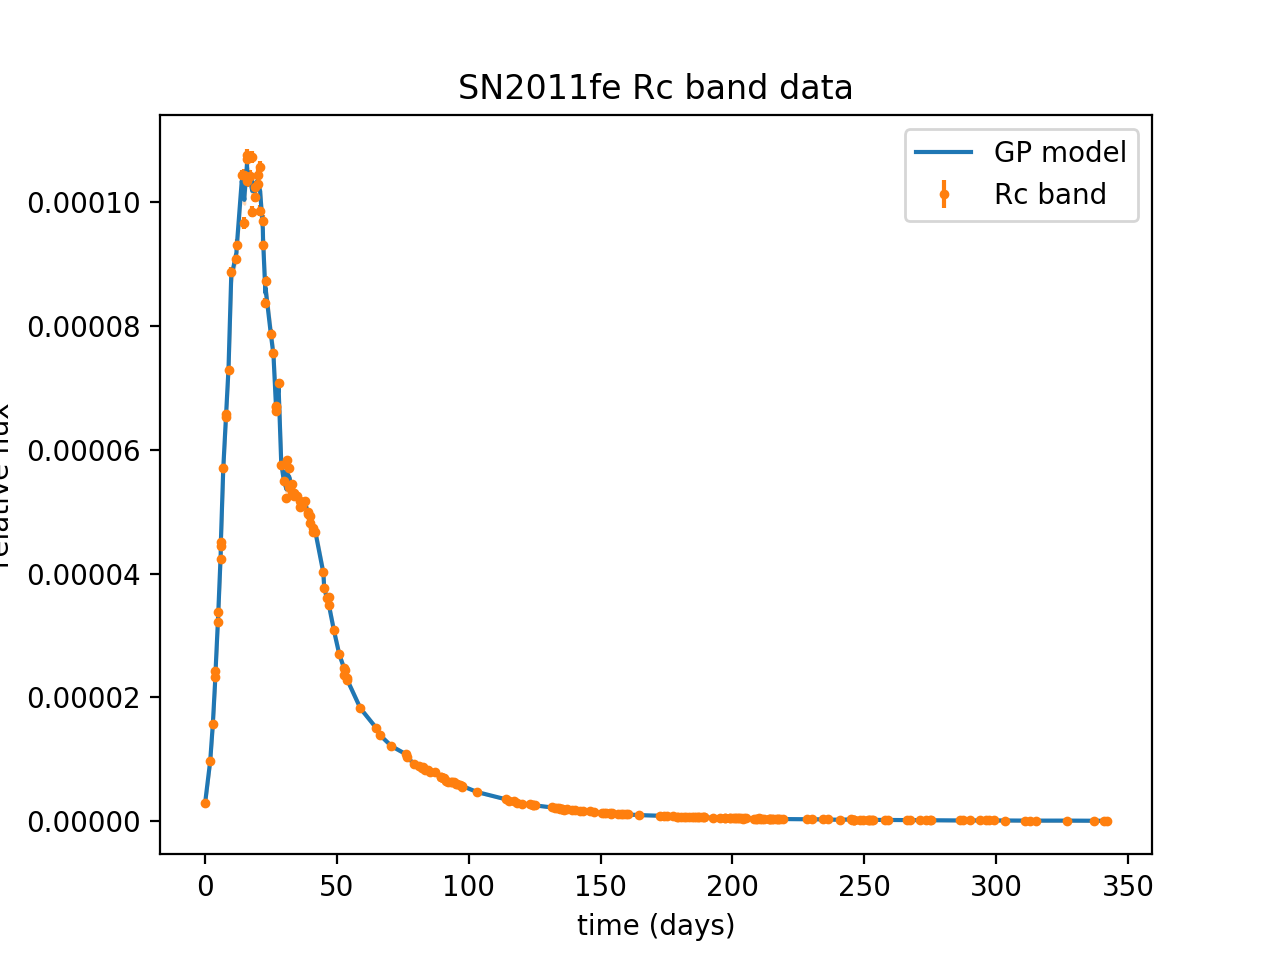

In [17]:
color = "#ff7f0e"
plt.figure()
plt.plot(time, pred_mean, label='GP model')
plt.errorbar(time, flux, fmt='o', yerr=flux_err, label='Rc band', markersize= 2.5)
plt.fill_between(time, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.legend()
plt.title('')
plt.xlabel('time (days)')
plt.ylabel('relative flux')

plt.title('SN2011fe Rc band data')
plt.show()

In [15]:
def calc_Rchi2(Supernovae):
    flux = Supernovae.Lightcurves['Rc_12'].flux
    time = Supernovae.Lightcurves['Rc_12'].time
    flux_err = Supernovae.Lightcurves['Rc_12'].flux_err
    flux_predictions = np.empty(flux.shape) * np.nan
    #loop to run 'leave one out' CV
    for ind, f in enumerate(flux):
            flux_err_del = np.delete(flux_err, ind)
            flux_del = np.delete(flux, ind)
            time_del = np.delete(time, ind)
            gp.compute(time_del, flux_err_del)
            r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=((flux_del, gp)))
            gp.set_parameter_vector(r.x)
            pred_mean, pred_var = gp.predict(flux_del, time[ind], return_var=True)
            flux_predictions[ind] = pred_mean
        
    
    
    #Root Mean Square Error calculations
    dif = (flux_predictions - flux)/flux_err
    
    temp = np.sum(dif**2)
    
    temp = temp / (len(flux) - 6)
    Rchi2 = np.sqrt(temp)
    return Rchi2
calc_Rchi2(SN2011fe)


18.424698188461392

<IPython.core.display.Javascript object>


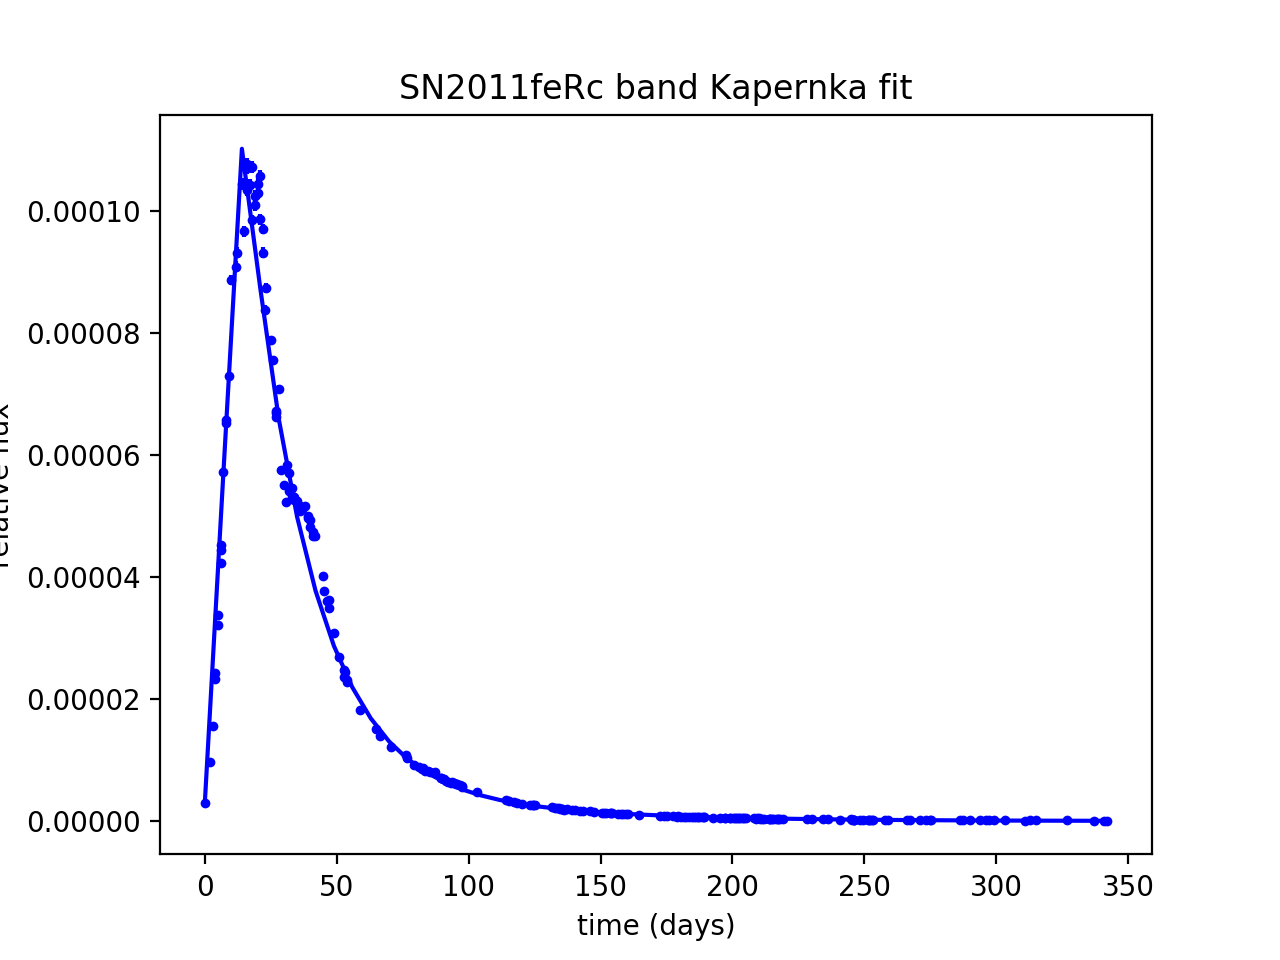

153.70942523720362

In [16]:
plt.figure()
SN2011fe.Lightcurves['Rc_12'].Kapernka_fit_plot()